# Reinforcement Learning Homework

Before you turn this notebook in, make sure everything runs as expected. First, **restart the kernel** (in the menu bar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menu bar, select Cell $\rightarrow$ Run All). You can also perform the two operations in one step (in the menu bar, select Kernel $\rightarrow$ Restart & Run All).

Make sure you fill in any place (or anywhere that you want in the code) that says `YOUR CODE HERE` or "YOUR ANSWER HERE", and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run). This is a reminder for you to complete all parts of the notebook. You can also send an incomplete notebook, but please remove all 'raise'-lines in any case.

You are not required to modify the code only where the line `YOUR CODE HERE` appears. In fact you can modify the given function and code as you want. Those are just reminders.

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your code, since this is the way we will do it before evaluating your notebook!

Fill in your name and ID number (matricola) below:

In [1]:
NAME = 'Stefano'
ID_number = int('2052421')

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# The 10 armed testbed

The code below generates the figures you can find in chapter 2 of "Reinforcement Learning: An Introduction" by Andrew Barto and Richard S. Sutton. The main issue is the multi-armed bandit problem, whcih is addressed through epsilon-greedy, UCB and and gradient bandit algorithms: in order to do so, the 10 armed testbed is introduced.

In [2]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

## Bandit class

Here the arm selection strategy is part of the Bandit environment: this is managed through instance variables specifying which algorithm will be used to solve the environment and its parameters.

In [4]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        # commento: potrebbe essere il settaggio randomico delle distribuzioni di probabilità di vincita delle singole
        #           azioni per i dieci diversi bandit.
        self.q_true = np.random.randn(self.k) + self.true_reward 

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial 

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        # leva migliore da tirare per ottenere più reward
        self.best_action = np.argmax(self.q_true) # the true best action is only one

        self.time = 0

    # get an action for this bandit
    # l'azione sarebbe l'indice della leva da tirare
    def act(self): # action = bandit.act()
        
        # condizione epsilon-greedy policy
        # Questa condizione indica che si sceglie la non-greedy action con probabiltà epsilon.
        # Se rand fosse > di epsilon allora si verificherebbe la condizione greedy con probabilità 1 - epsilon nei due if sottostanti  
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices) 

        # condizione UCB
        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))#perchè evitare denominatore pari a zero
            q_best = np.max(UCB_estimation)#max
            return np.random.choice(np.where(UCB_estimation == q_best)[0])#argmax

        # condizione 
        if self.gradient:
            exp_est = np.exp(self.q_estimation)#usare i sample average estimation come valori di preferenza H(a) del quaderno
            self.action_prob = exp_est / np.sum(exp_est) # [.9, .05, .05]
            return np.random.choice(self.indices, p=self.action_prob)

        # greedy action (condizione con probabilità 1-epsilon della epsilon-greedy policy)
        q_best = np.max(self.q_estimation) # [0, 0, 0]
        # break ties arbitrarily, action is chosen at random between those that have best (estimated) value
        return np.random.choice(np.where(self.q_estimation == q_best)[0]) 

    # take an action, update estimation for this action
    def step(self, action): # bandit.step(action)
        # generate the reward under N(real reward, 1)
        # usa q_true come media della distribuzione perchè q_true sarebbe il SAMPLE AVERAGE, cioè la media dei reward
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        # calcolo reward medio R_t "hat" per la formula del gradient bandit H_t+1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            #check se usare o meno la baseline o reward medio
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)

        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

The simulate function allows you to actually run different bandit environments multiple times to average the performance metrics.

In [5]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):  # progress bar
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1) # average of runs
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards # n_bandits x time

Visualization of the 10 armed testbed.

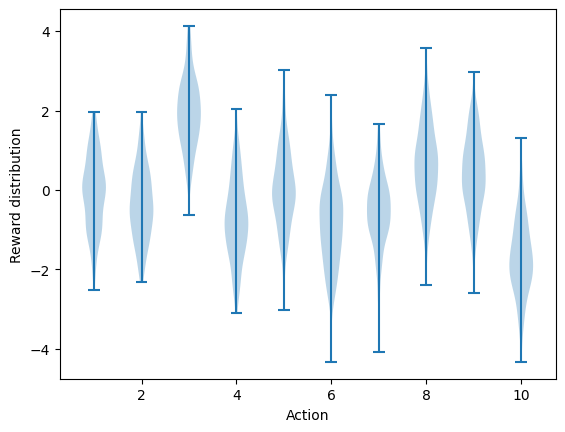

In [6]:
## FIGURE 2.1

plt.violinplot(dataset=np.random.randn(200, 10) + np.random.randn(10))
                        #"generates the stds"      "generates means"
plt.xlabel("Action")
plt.ylabel("Reward distribution")

plt.show()

Comparison between different values of epsilon parameter for epsilon-greedy algorithms.

100%|██████████| 2000/2000 [00:45<00:00, 43.86it/s]


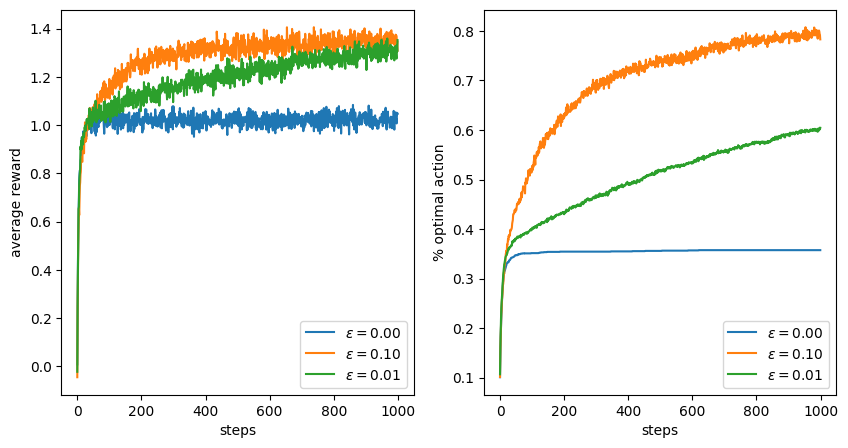

In [7]:
## FIGURE 2.2

runs=2000; time=1000 

epsilons = [0, 0.1, 0.01] # bandit = Bandit(epsilon=.9)
bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
best_action_counts, rewards = simulate(runs, time, bandits)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
for eps, rewards in zip(epsilons, rewards):
    plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(1, 2, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

plt.show()

Exploration through initial optimism.

100%|██████████| 2000/2000 [00:49<00:00, 40.59it/s]


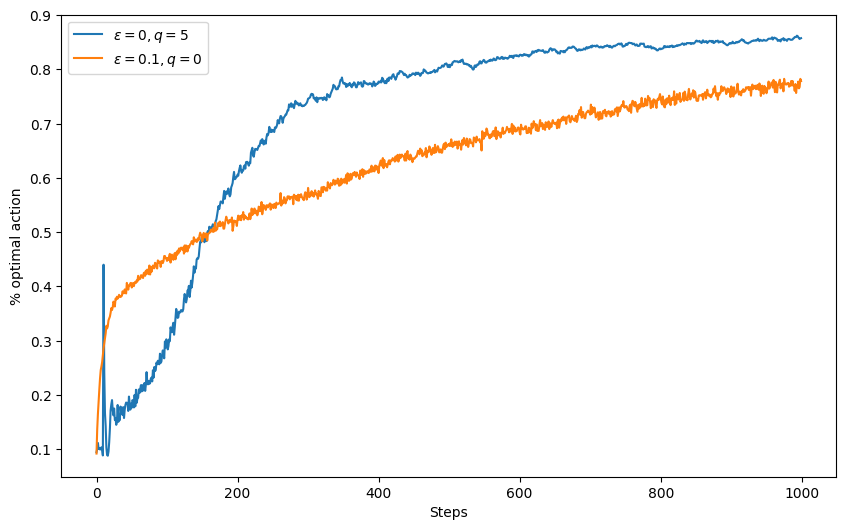

In [8]:
## FIGURE 2.3

bandits = []
bandits.append(Bandit(epsilon=0, initial=5, step_size=0.1))  # initializes all estimates to 5
bandits.append(Bandit(epsilon=0.1, initial=0, step_size=0.1))
best_action_counts, _ = simulate(runs, time, bandits)

plt.figure(figsize=(10, 6))

plt.plot(best_action_counts[0], label='$\epsilon = 0, q = 5$')
plt.plot(best_action_counts[1], label='$\epsilon = 0.1, q = 0$')
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()


plt.show()

In [9]:
### COMMENTS ON THE PLOT ABOVE

#it explores a LOT in the beginning, so this drops the performance, because it always changes the action chosen
#In the plot each "% optimal action refers to only THE action chosen in the step"
#Since it explores all actions, The initial spike is related to the best action among them

Comparison between epsilon-greedy and UCB algorithms.

100%|██████████| 2000/2000 [00:50<00:00, 39.90it/s]


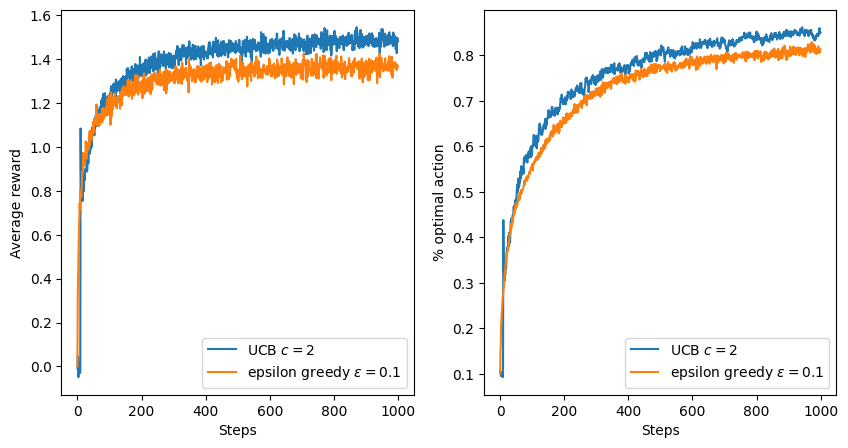

In [10]:
## FIGURE 2.4

bandits = []
bandits.append(Bandit(epsilon=0, UCB_param=2, sample_averages=True))
bandits.append(Bandit(epsilon=0.1, sample_averages=True))
best_action_counts, average_rewards = simulate(runs, time, bandits)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(average_rewards[0], label='UCB $c = 2$')
plt.plot(average_rewards[1], label='epsilon greedy $\epsilon = 0.1$')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_action_counts[0], label='UCB $c = 2$')
plt.plot(best_action_counts[1], label='epsilon greedy $\epsilon = 0.1$')
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()

plt.show()

Baseline imporovement in bandit gradient algorithm.

100%|██████████| 2000/2000 [01:44<00:00, 19.17it/s]


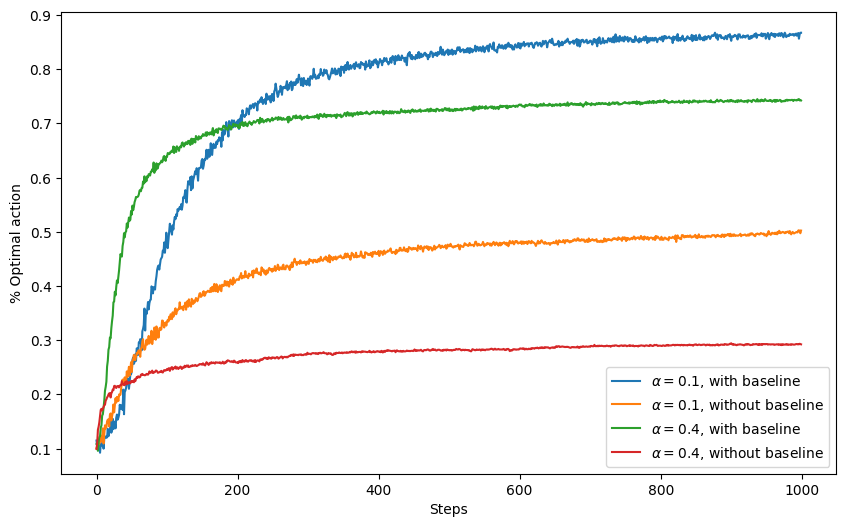

In [11]:
## FIGURE 2.5

bandits = []
bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
best_action_counts, _ = simulate(runs, time, bandits)
labels = [r'$\alpha = 0.1$, with baseline',
          r'$\alpha = 0.1$, without baseline',
          r'$\alpha = 0.4$, with baseline',
          r'$\alpha = 0.4$, without baseline']

plt.figure(figsize=(10, 6))

for i in range(len(bandits)):
    plt.plot(best_action_counts[i], label=labels[i])
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()

plt.show()

100%|██████████| 2000/2000 [01:34<00:00, 21.06it/s]


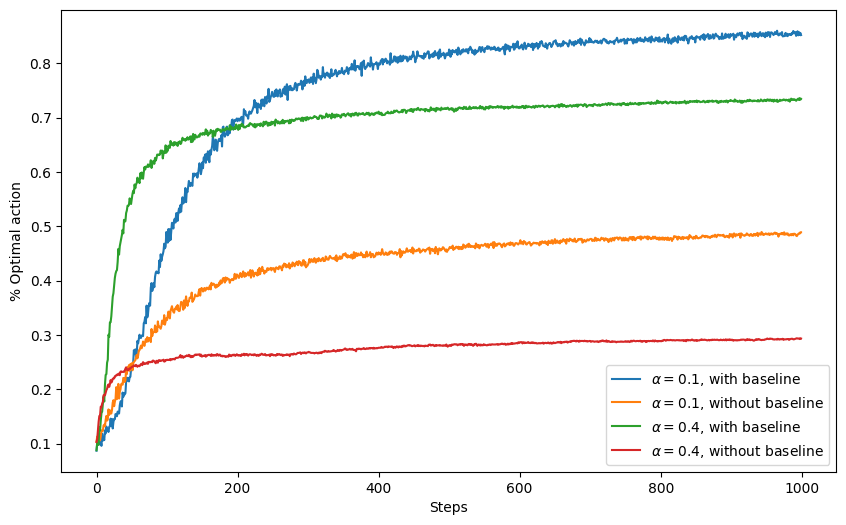

In [12]:
## FIGURE 2.5

bandits = []
bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
best_action_counts, _ = simulate(runs, time, bandits)
labels = [r'$\alpha = 0.1$, with baseline',
          r'$\alpha = 0.1$, without baseline',
          r'$\alpha = 0.4$, with baseline',
          r'$\alpha = 0.4$, without baseline']

plt.figure(figsize=(10, 6))

for i in range(len(bandits)):
    plt.plot(best_action_counts[i], label=labels[i])
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()

plt.show()

In [13]:
###  with higher step sizes we risk to skip the optimal higher value of the function

Analysis of algorithms as parameters change.

C:\Users\stefa\AppData\Local\Temp\ipykernel_4576\4019437283.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  parameters = [np.arange(-7, -1, dtype=np.float),
C:\Users\stefa\AppData\Local\Temp\ipykernel_4576\4019437283.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.arange(-5, 2, dtype=np.float),
C:\Users\stefa\AppData\Local\Temp

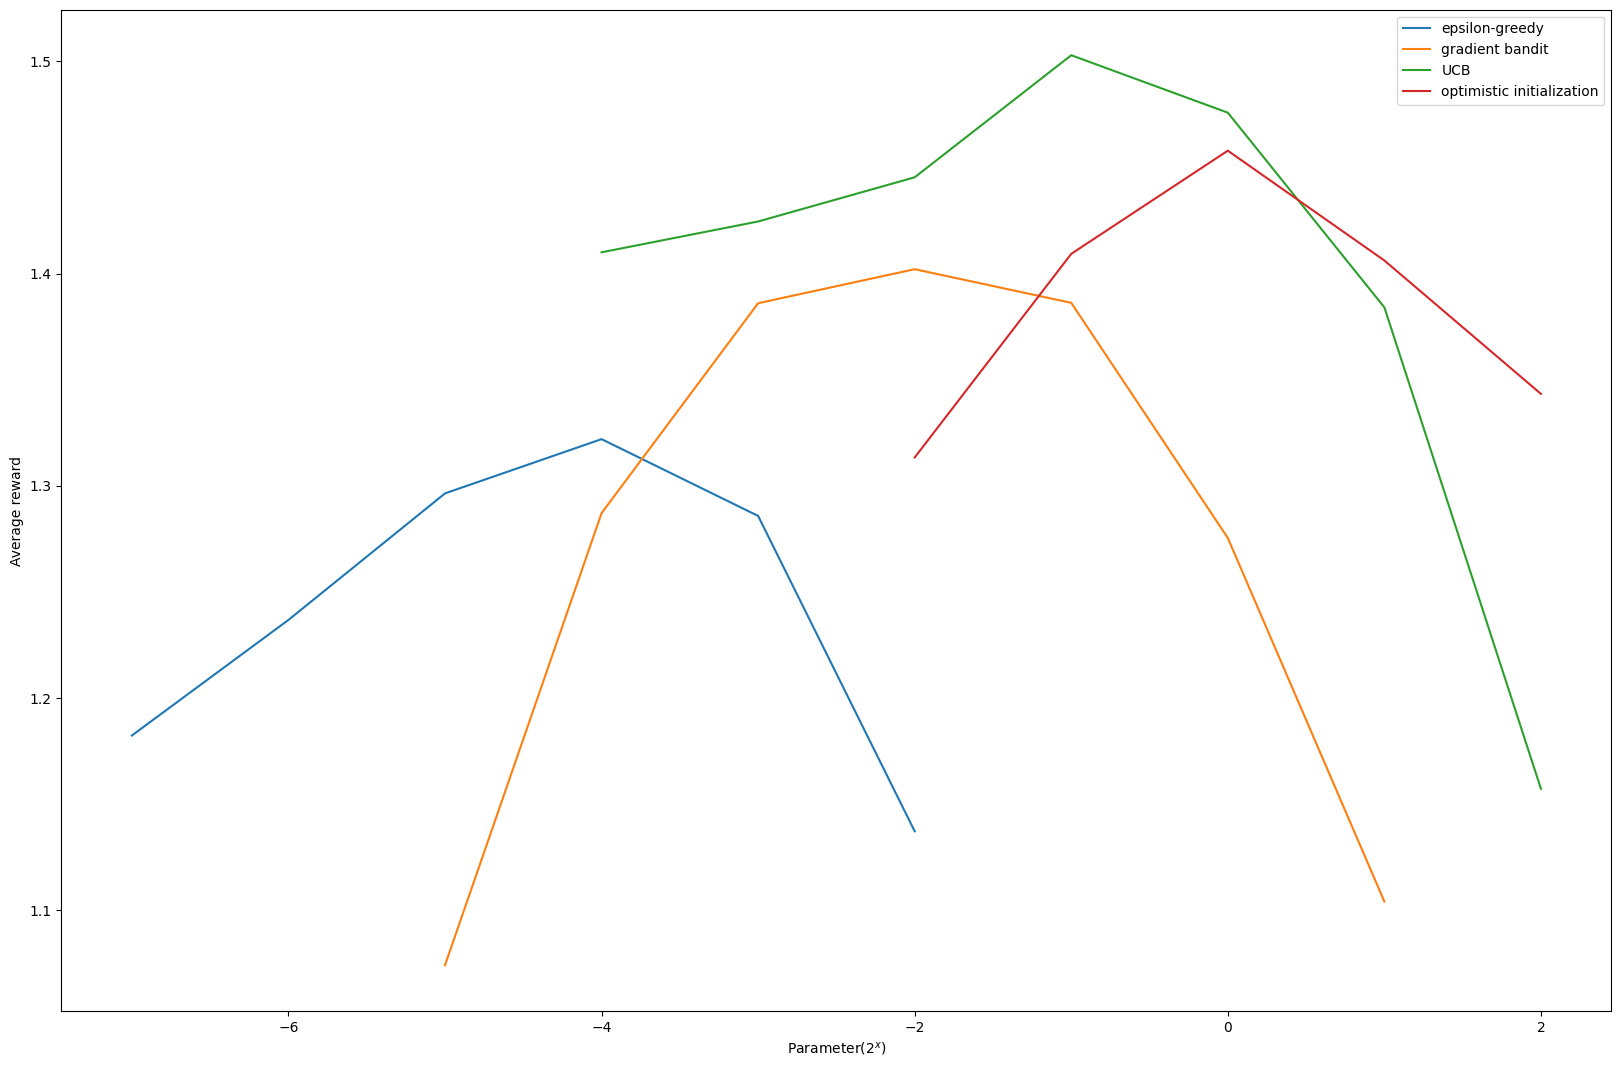

In [14]:
## FIGURE 2.6
labels = ['epsilon-greedy', 'gradient bandit',
          'UCB', 'optimistic initialization']
generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
              lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
              lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True),
              lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)]
parameters = [np.arange(-7, -1, dtype=np.float),
              np.arange(-5, 2, dtype=np.float),
              np.arange(-4, 3, dtype=np.float),
              np.arange(-2, 3, dtype=np.float)]

bandits = []
for generator, parameter in zip(generators, parameters):
    for param in parameter:
        bandits.append(generator(pow(2, param)))

_, average_rewards = simulate(runs, time, bandits)
rewards = np.mean(average_rewards, axis=1)

plt.figure(figsize=(20, 13))

i = 0
for label, parameter in zip(labels, parameters):
    l = len(parameter)
    plt.plot(parameter, rewards[i:i+l], label=label)
    i += l
plt.xlabel('Parameter($2^x$)')
plt.ylabel('Average reward')
plt.legend()

plt.show()

In [15]:
# From last test
best_params = [-4, -2, 0, 0]

times = 1000 * np.arange(10)  # * np.array([1, 5, 10]) (less resolution)
time_efficiency = np.zeros((4, times.shape[0]))

# Setup the 4 algorithms and run your code to test each algorithm's time efficiency

# YOUR CODE HERE
raise NotImplementedError() # Remove this line

for i in range(time_efficiency.shape[0]):  # for each bandit
    plt.plot(times, time_efficiency[i, :], label=labels[i])
    
plt.xlabel('max interaction time')
plt.ylabel('Average reward')
plt.legend()
plt.show()

NotImplementedError: 